## Packages

In [55]:
# Pkg.add("DifferentialEquations")
# Pkg.add("ModelingToolkit")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("Statistics")
# Pkg.add("StaticArrays")
# Pkg.add("Sundials")

In [56]:
using Pkg
using Plots
using DifferentialEquations
using DataFrames
using StaticArrays
using Statistics
using Sundials


## Parameters and Initial condition definition

In [57]:
@kwdef struct parma_evo_comp
    B::Float64 = 1.0
    d::Float64 = 1.0
    var::Float64 = 1.0
    gamma0::Float64 = 0.1
    vit::Float64 = 50.0
    rv::Float64 = 0.1
    p1::Float64 = 10.0
    p2::Float64 = 0.5
    m::Float64 = 1.0
    g::Float64=0.01

end

param_basic = parma_evo_comp()

#Initials condition

@kwdef struct IniV_evo_comp
    S0::Float64 = 0.9
    I0::Float64 = 0.1
    v0::Float64 = 0.5
    x0::Float64 = 0.1
    y0::SVector{3,Float64} = SVector(S0,I0,x0)
    u0::SVector{4,Float64} = SVector(S0,I0,x0,v0)
end



iniv = IniV_evo_comp() 

#Time

@kwdef struct ParTime
    tspan::Tuple{Float64,Float64} = (0.0,2000)
    tstep::Float64 = 0.1
end

linestyle_vec =[ :dash, :dashdot, :dashdotdot, :dot, :solid]

ptime =ParTime()

ParTime((0.0, 2000.0), 0.1)

### Définition des fonctions

In [58]:
# Structure de param
function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
    (;B,d,var,gamma0,vit,rv,p1,p2,m,g) = p

    S =init[1]
    I =init[2]
    x =init[3]
    vir = init[4]

    rap_cost = rv / (vir /(vir + d+g))
    I_biais = I


    
    dS = B*(1-x) - d *S - beta(vir,p) * S *I
    dI = beta(vir,p) * S *I - (g+d +  vir)*I
    dx = vit * x *(1 - x) * (  I_biais   - rap_cost)
    dv = var *(beta_prime(vir,p) * (S + gamma0 * I) - 1 ) 
    
    return SVector(dS,dI,dx,dv)
end



function beta(x::Real,p::parma_evo_comp)
    (;p1,p2) = p
    return ((x*p1)/(p2+x))
end

function beta_prime(x::Real,p::parma_evo_comp)
    (;p1,p2) = p
    return ((p1*p2)/(p2+x)^2)
end



beta_prime (generic function with 1 method)

### Simulation function

In [59]:


function sim_mod(init ,p::parma_evo_comp ,pt::ParTime,solveur )
    (;tspan,tstep) = pt
    (; u0) = init
    
    prob_mod = ODEProblem(mod_vac_evo_comp,u0,tspan,p,saveat = tstep)
    
    sol_mod = solve(prob_mod,solveur,abstol = 1e-12,reltol = 1e-12)

    sol_mod = DataFrame(sol_mod)

    rename!(sol_mod,:timestamp => :time, :value1 => :S, :value2 => :I, :value3 => :x, :value4 => :v)
    return sol_mod
end 


function diagram_bif_1p_vit_var(nbr_val::Real,val1::Float64,val2::Float64,var_vec)

    vit_vec = range(val1,stop = val2,length = nbr_val)
    
    length_var = length(var_vec)

    tab_res_high = zeros(length_var, nbr_val)
    tab_res_low = zeros(length_var, nbr_val)

    ptime_bif_1 =ParTime(tspan = (0,5000))

    # BOucle pour les diagrammes bif
    for  y in 1:length(var_vec)
        for i in 1:length(vit_vec)

            param1_mod = vit_vec[i]
            param2_mod = var_vec[y]
            
            param_bif = parma_evo_comp(vit = param1_mod,p1 =11.5,p2 = 0.5,var =param2_mod) 
            sol = sim_mod(iniv,param_bif,ptime_bif_1,Vern9())
        
            nb_pas = length(sol.time)
            last_10per = ( nb_pas - (round(Int,nb_pas/2)) : nb_pas)
                
            xmin = minimum(sol.I[last_10per])
            xmax = maximum(sol.I[last_10per])

            tab_res_low[y,i] = xmin
            tab_res_high[y,i] = xmax

                

        end
    end 


    # plotting
    plt = plot(vit_vec, tab_res_low[1,:], color="black", linewidth=2,linestyle =linestyle_vec[1],label = string(var_vec[1]))
    plot!(vit_vec, tab_res_high[1,:], color="black", linewidth=2,linestyle =linestyle_vec[1],label="")
   

        for k in (1:length_var - 1)

            vec_low =tab_res_low[k+1,:]
            vec_high =tab_res_high[k+1,:]

            plot!(vit_vec, vec_low,  color="black", linewidth=2,linestyle =linestyle_vec[k+1],label = string(var_vec[k+1]))
            plot!(vit_vec, vec_high,  color="black", linewidth=2,linestyle =linestyle_vec[k+1],label="")
        end


    #title!("Bifurcation diagram ")
    xlabel!("Sampling rate")
    ylabel!("I at equilibrium")

    return(plt)
end




function diagram_bif_1p_rv_var(nbr_val::Real,val1::Float64,val2::Float64,var_vec)

    rv_vec = range(val1,stop = val2,length = nbr_val)
    
    length_var = length(var_vec)

    tab_res_high = zeros(length_var, nbr_val)
    tab_res_low = zeros(length_var, nbr_val)

    ptime_bif_1 =ParTime(tspan = (0,5000))

    # BOucle pour les diagrammes bif
    for  y in 1:length(var_vec)
        for i in 1:length(rv_vec)

            param1_mod = rv_vec[i]
            param2_mod = var_vec[y]
            
            param_bif = parma_evo_comp(rv = param1_mod,p1 =11.5,p2 = 0.5,var =param2_mod) 
            sol = sim_mod(iniv,param_bif,ptime_bif_1,Vern9())
        
            nb_pas = length(sol.time)
            last_10per = ( nb_pas - (round(Int,nb_pas/2)) : nb_pas)
                
            xmin = minimum(sol.I[last_10per])
            xmax = maximum(sol.I[last_10per])

            tab_res_low[y,i] = xmin
            tab_res_high[y,i] = xmax

                

        end
    end 


    # Plotting
    plt = plot(rv_vec, tab_res_low[1,:], color="black", linewidth=2,linestyle =linestyle_vec[1],label = string(var_vec[1]))
    plot!(rv_vec, tab_res_high[1,:], color="black", linewidth=2,linestyle =linestyle_vec[1],label="")
   

        for k in (1:length_var - 1)

            vec_low =tab_res_low[k+1,:]
            vec_high =tab_res_high[k+1,:]

            plot!(rv_vec, vec_low,  color="black", linewidth=2,linestyle =linestyle_vec[k+1],label = string(var_vec[k+1]))
            plot!(rv_vec, vec_high,  color="black", linewidth=2,linestyle =linestyle_vec[k+1],label="")
        end

    #title!("Bifurcation diagram ")
    xlabel!("Percieveid vaccine morbidity")
    ylabel!("I at equilibrium")

    return(plt)
end



function bifurcation_diagram_2p(nbr_val::Real,pt::ParTime,solvee,low_vit::Float64,high_vit::Float64,low_rv::Float64,high_rv::Float64)

    rv_vec = range(low_rv,stop = high_rv,length = nbr_val)
    vit_vec = range(low_vit,stop = high_vit,length = nbr_val)
    tab_res = zeros(nbr_val, nbr_val)

    
    
    # BOucle pour les diagrammes bif 
    for i in 1:length(rv_vec)
        for y in 1:length(vit_vec)

        rv_mod = rv_vec[i]
        vit_mod = vit_vec[y]
            
        param_bif = parma_evo_comp(rv = rv_mod,vit =vit_mod,p1 = 10,p2 = 0.5) 
        sol = sim_mod(iniv,param_bif,pt,solvee)
    
        nb_pas = length(sol.time)
        last_10per = ( nb_pas - (round(Int,nb_pas/4)) : nb_pas)
                
        xmin = minimum(sol.x[last_10per])
    
        xmax = maximum(sol.x[last_10per])

        cond1 = minimum(sol.S[last_10per])
    
        cond2 = maximum(sol.S[last_10per])
    
        if sol.I[nb_pas] < -1e-12
            tab_res[y,i] = 6
            print(sol.I[nb_pas])
        elseif minimum(sol.v)  < -1e-12 #(sol.v[nb_pas-10] <0 && sol.v[nb_pas-25] <0 && sol.v[nb_pas] <0)
            tab_res[y,i] = 5
        elseif minimum(sol.x[nb_pas-500:nb_pas]) > 0.99999 
            tab_res[y,i] = 4
        elseif sol.x[nb_pas] <1e-12 && (xmax - xmin <1e-12)  #|| cond2 - cond1 < 0.0001  ) #&& sol2.x[nb_pas-1000] <1e-12 && sol2.x[nb_pas-700] <1e-12
            tab_res[y,i] = 1
        elseif xmax - xmin <0.01
            tab_res[y,i] = 2
        elseif xmax - xmin >0.01
            tab_res[y,i] = 3
        end

    
            end
        end
    
        return tab_res
    
end





bifurcation_diagram_2p (generic function with 1 method)

In [60]:
function diagram_bif_vir(nbr_val::Real,pt::ParTime,solvee,low_vit::Float64,high_vit::Float64,low_rv::Float64,high_rv::Float64)
    rv_vec = range(low_rv,stop = high_rv,length = nbr_val)
    vit_vec = range(low_vit,stop = high_vit,length = nbr_val)
    heatmap_vir = zeros(nbr_val, nbr_val)

    
    
    # BOucle pour les diagrammes bif 
    for i in 1:length(rv_vec)
        for y in 1:length(vit_vec)

    
        rv_mod = rv_vec[i]
        vit_mod = vit_vec[y]
            
        param_bif = parma_evo_comp(rv = rv_mod,vit =vit_mod,p1 = 10,p2 = 0.5) 
        sol = sim_mod(iniv,param_bif,pt,solvee)
    
        nb_pas = length(sol.time)
        heatmap_vir[y,i] = maximum(sol.v[nb_pas-500:nb_pas])

            end
        end

        return heatmap_vir
    
end

diagram_bif_vir (generic function with 1 method)

### Plotting function

In [61]:
function plot_bif_diag(x,y,z,col_vec)



    heatmap(x, y, z, levels=[1,2,3], color=col_vec)

    xlabel!("Perceveid morbidty from vaccine")
    ylabel!("Sampling rate")
    #title!("Bifurcation diagram")
    
end

function time_plot(sol,pos)
    x = sol.time

    y1 = sol.S
    y2 = sol.I
    y3 = sol.x

    # Création du graphique
    plt = plot(x, y1, label="Susceptible", color="green", linewidth=2,dpi =500,legend = pos)
    plot!(x, y2, label="Infected", color="red", linewidth=2)
    plot!(x, y3, label="Cooperators", color="blue", linewidth=2)

    # Ajout du titre et des labels
    #title!("Time-series of susceptible, infected and cooperators")
    xlabel!("Time")
    ylabel!("Density")

    return plt
end




time_plot (generic function with 1 method)

### Série temporelle 

#### No epidemiologie

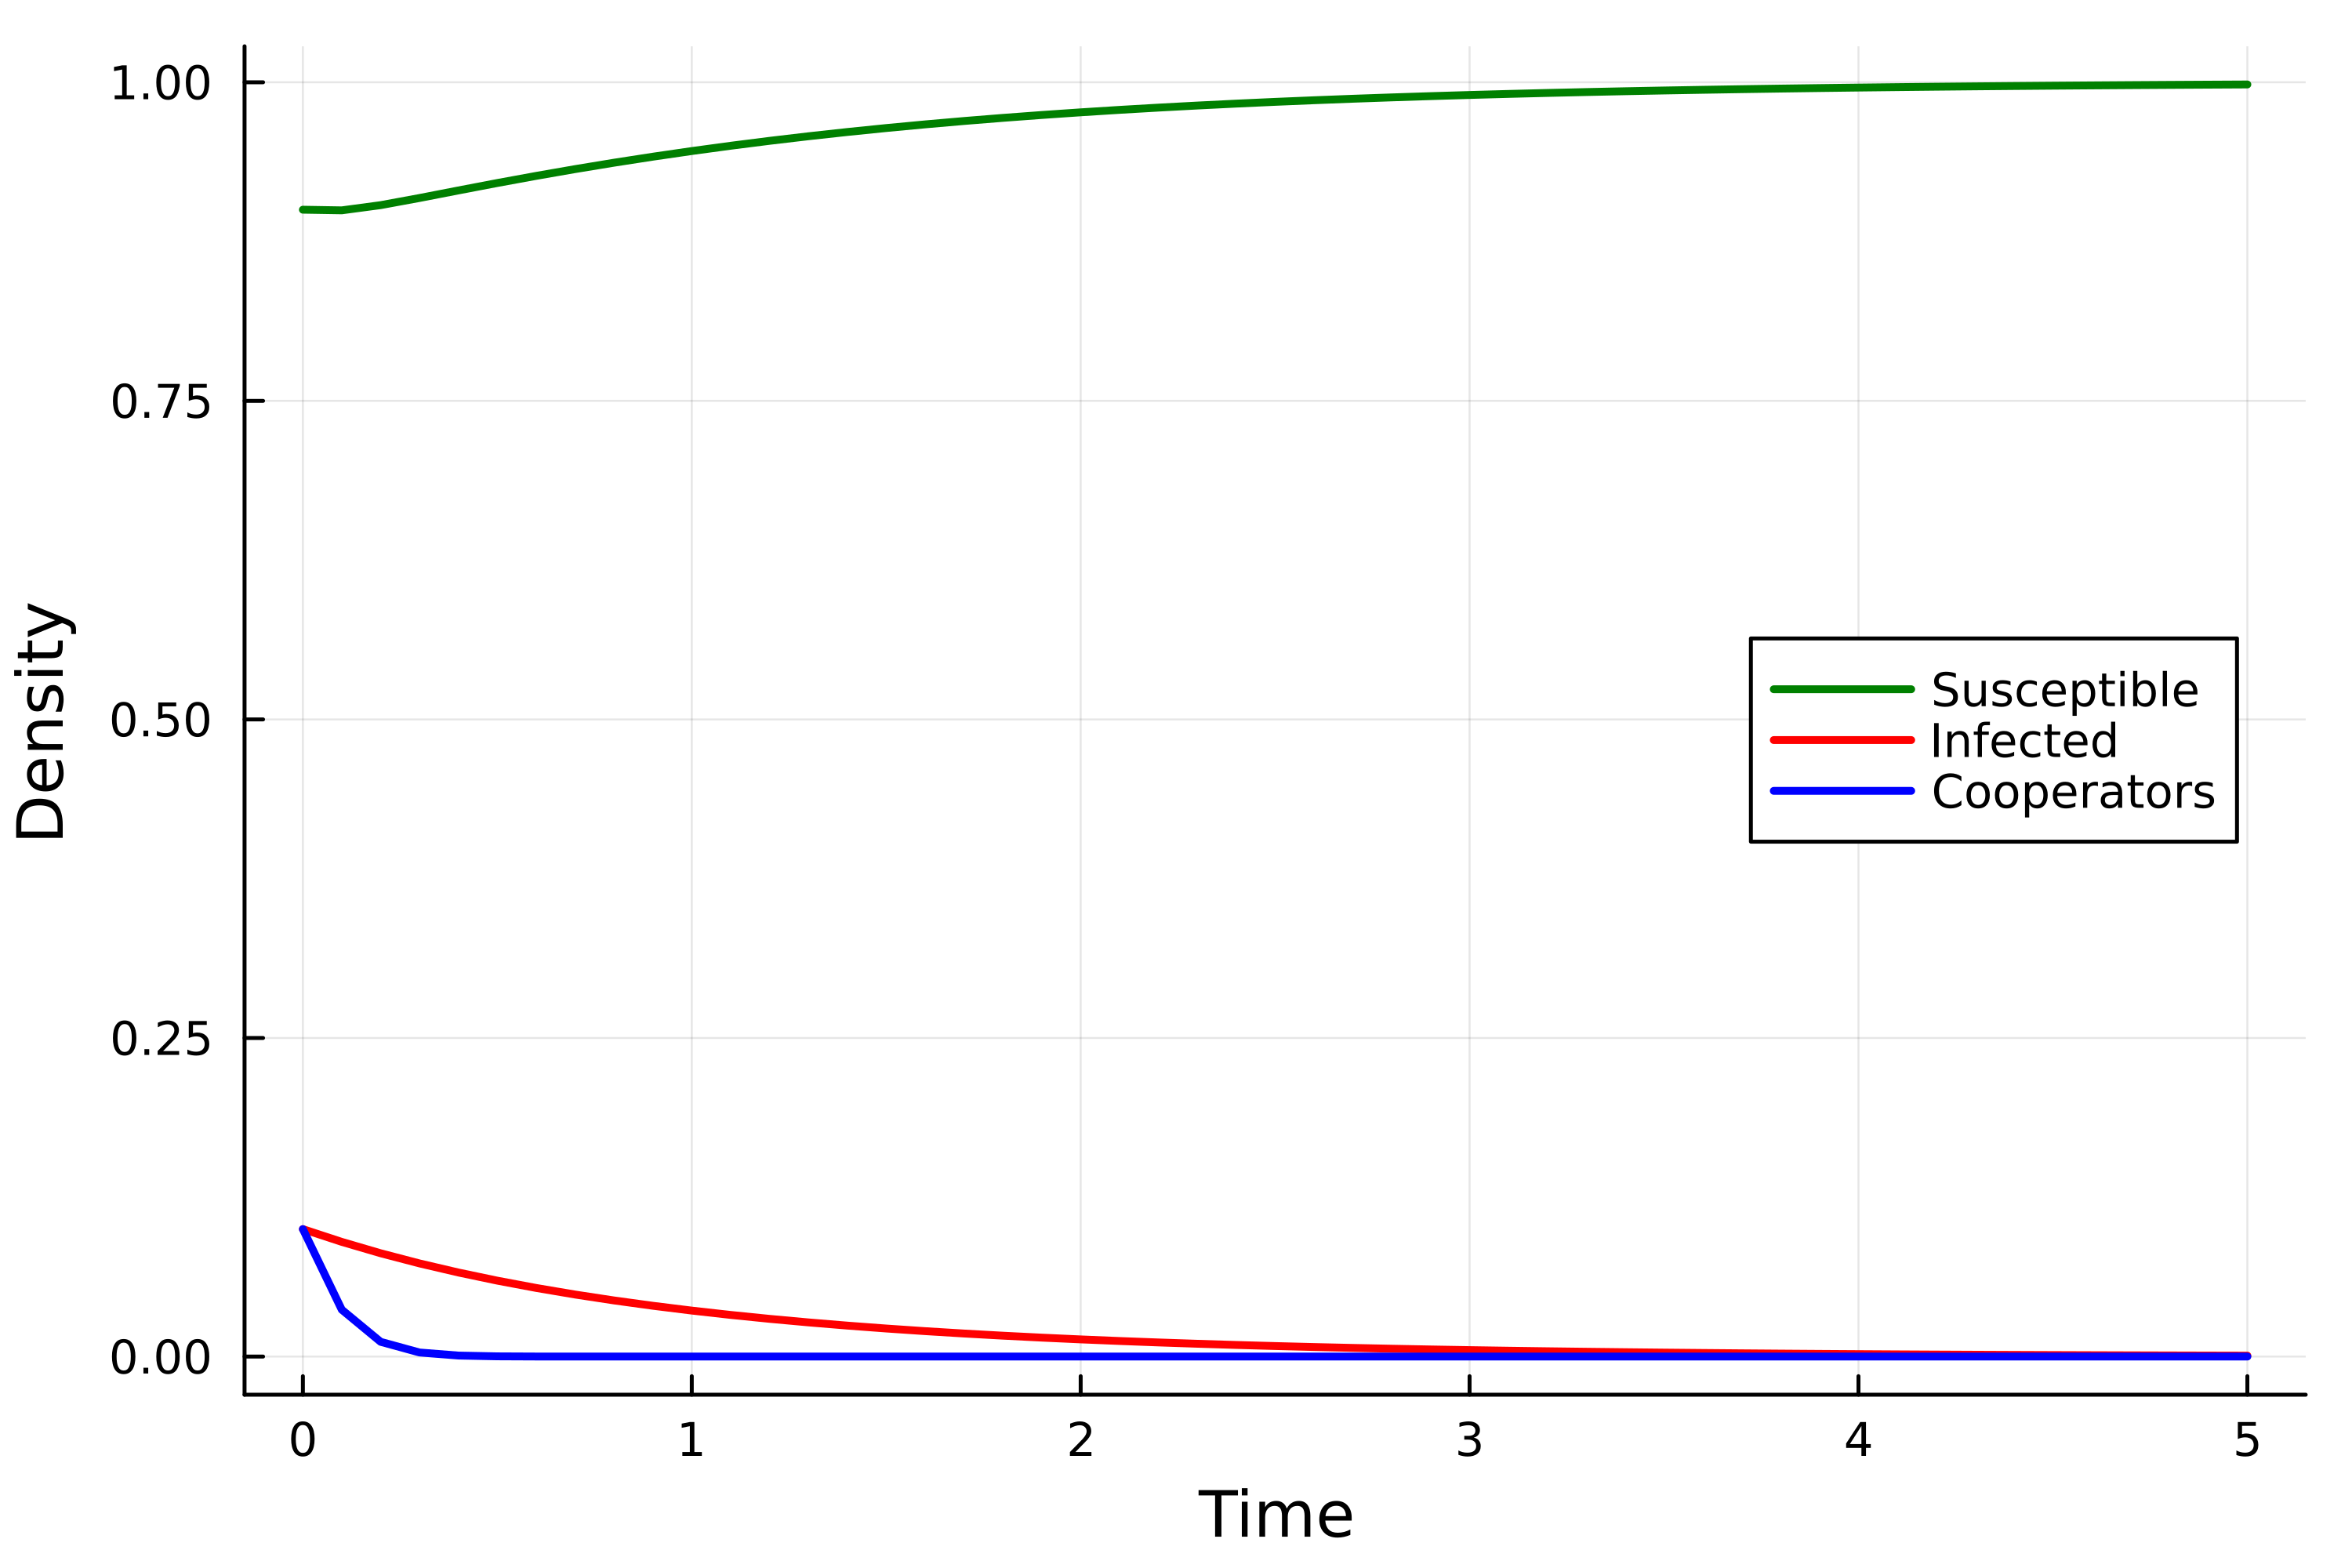

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\DFE.png"

In [62]:
ptime_serie =ParTime(tspan = (0,5))
param_DFE = parma_evo_comp(vit =50,rv = 0.1,p1 = 2,p2 = 1.5,var =1.0) 
sol_noepi = sim_mod(iniv ,param_DFE ,ptime_serie,Rosenbrock23() )
display(time_plot(sol_noepi,:right))

savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/DFE.png")

#### Absence de coopérateurs

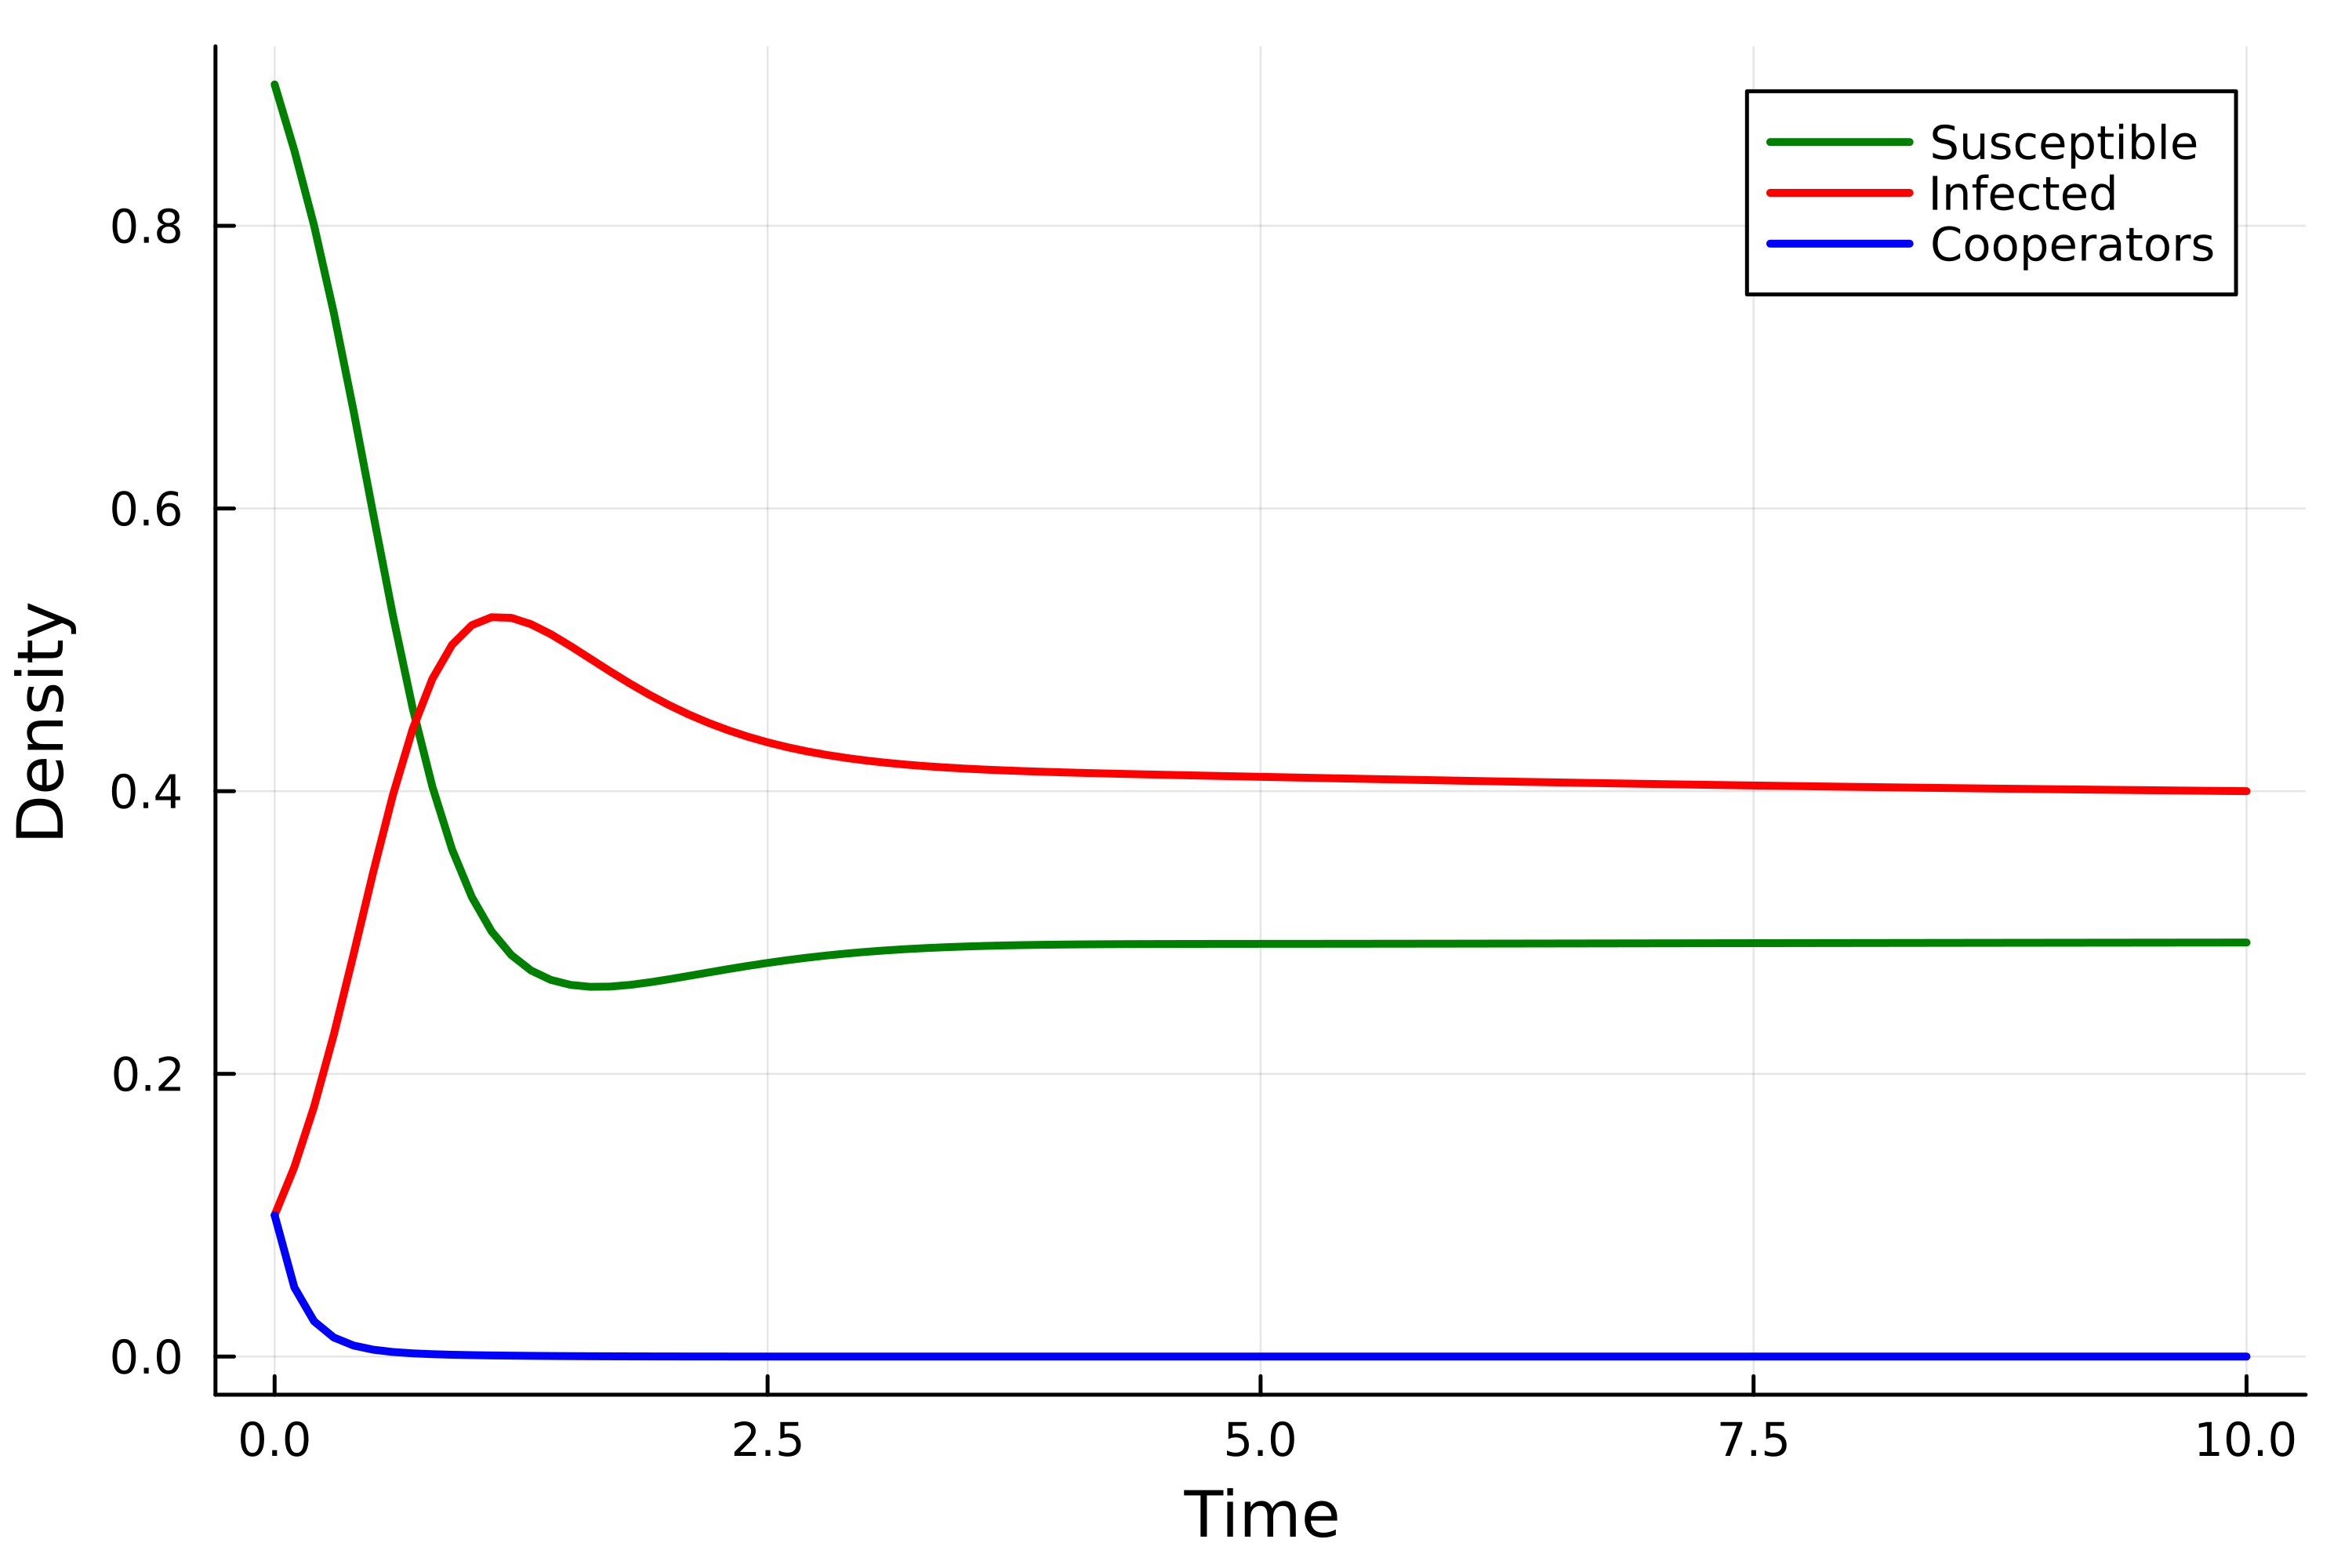

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\ENV.png"

In [63]:

ptime_serie =ParTime(tspan = (0,10))
param_ENV = parma_evo_comp(vit =10,rv = 0.3,p1 = 10,p2 = 0.5,var =0.1) 
sol = sim_mod(iniv ,param_ENV ,ptime_serie,Vern9() )

display(time_plot(sol,:topright))
savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/ENV.png")

#### Coopérateurs sans cycle

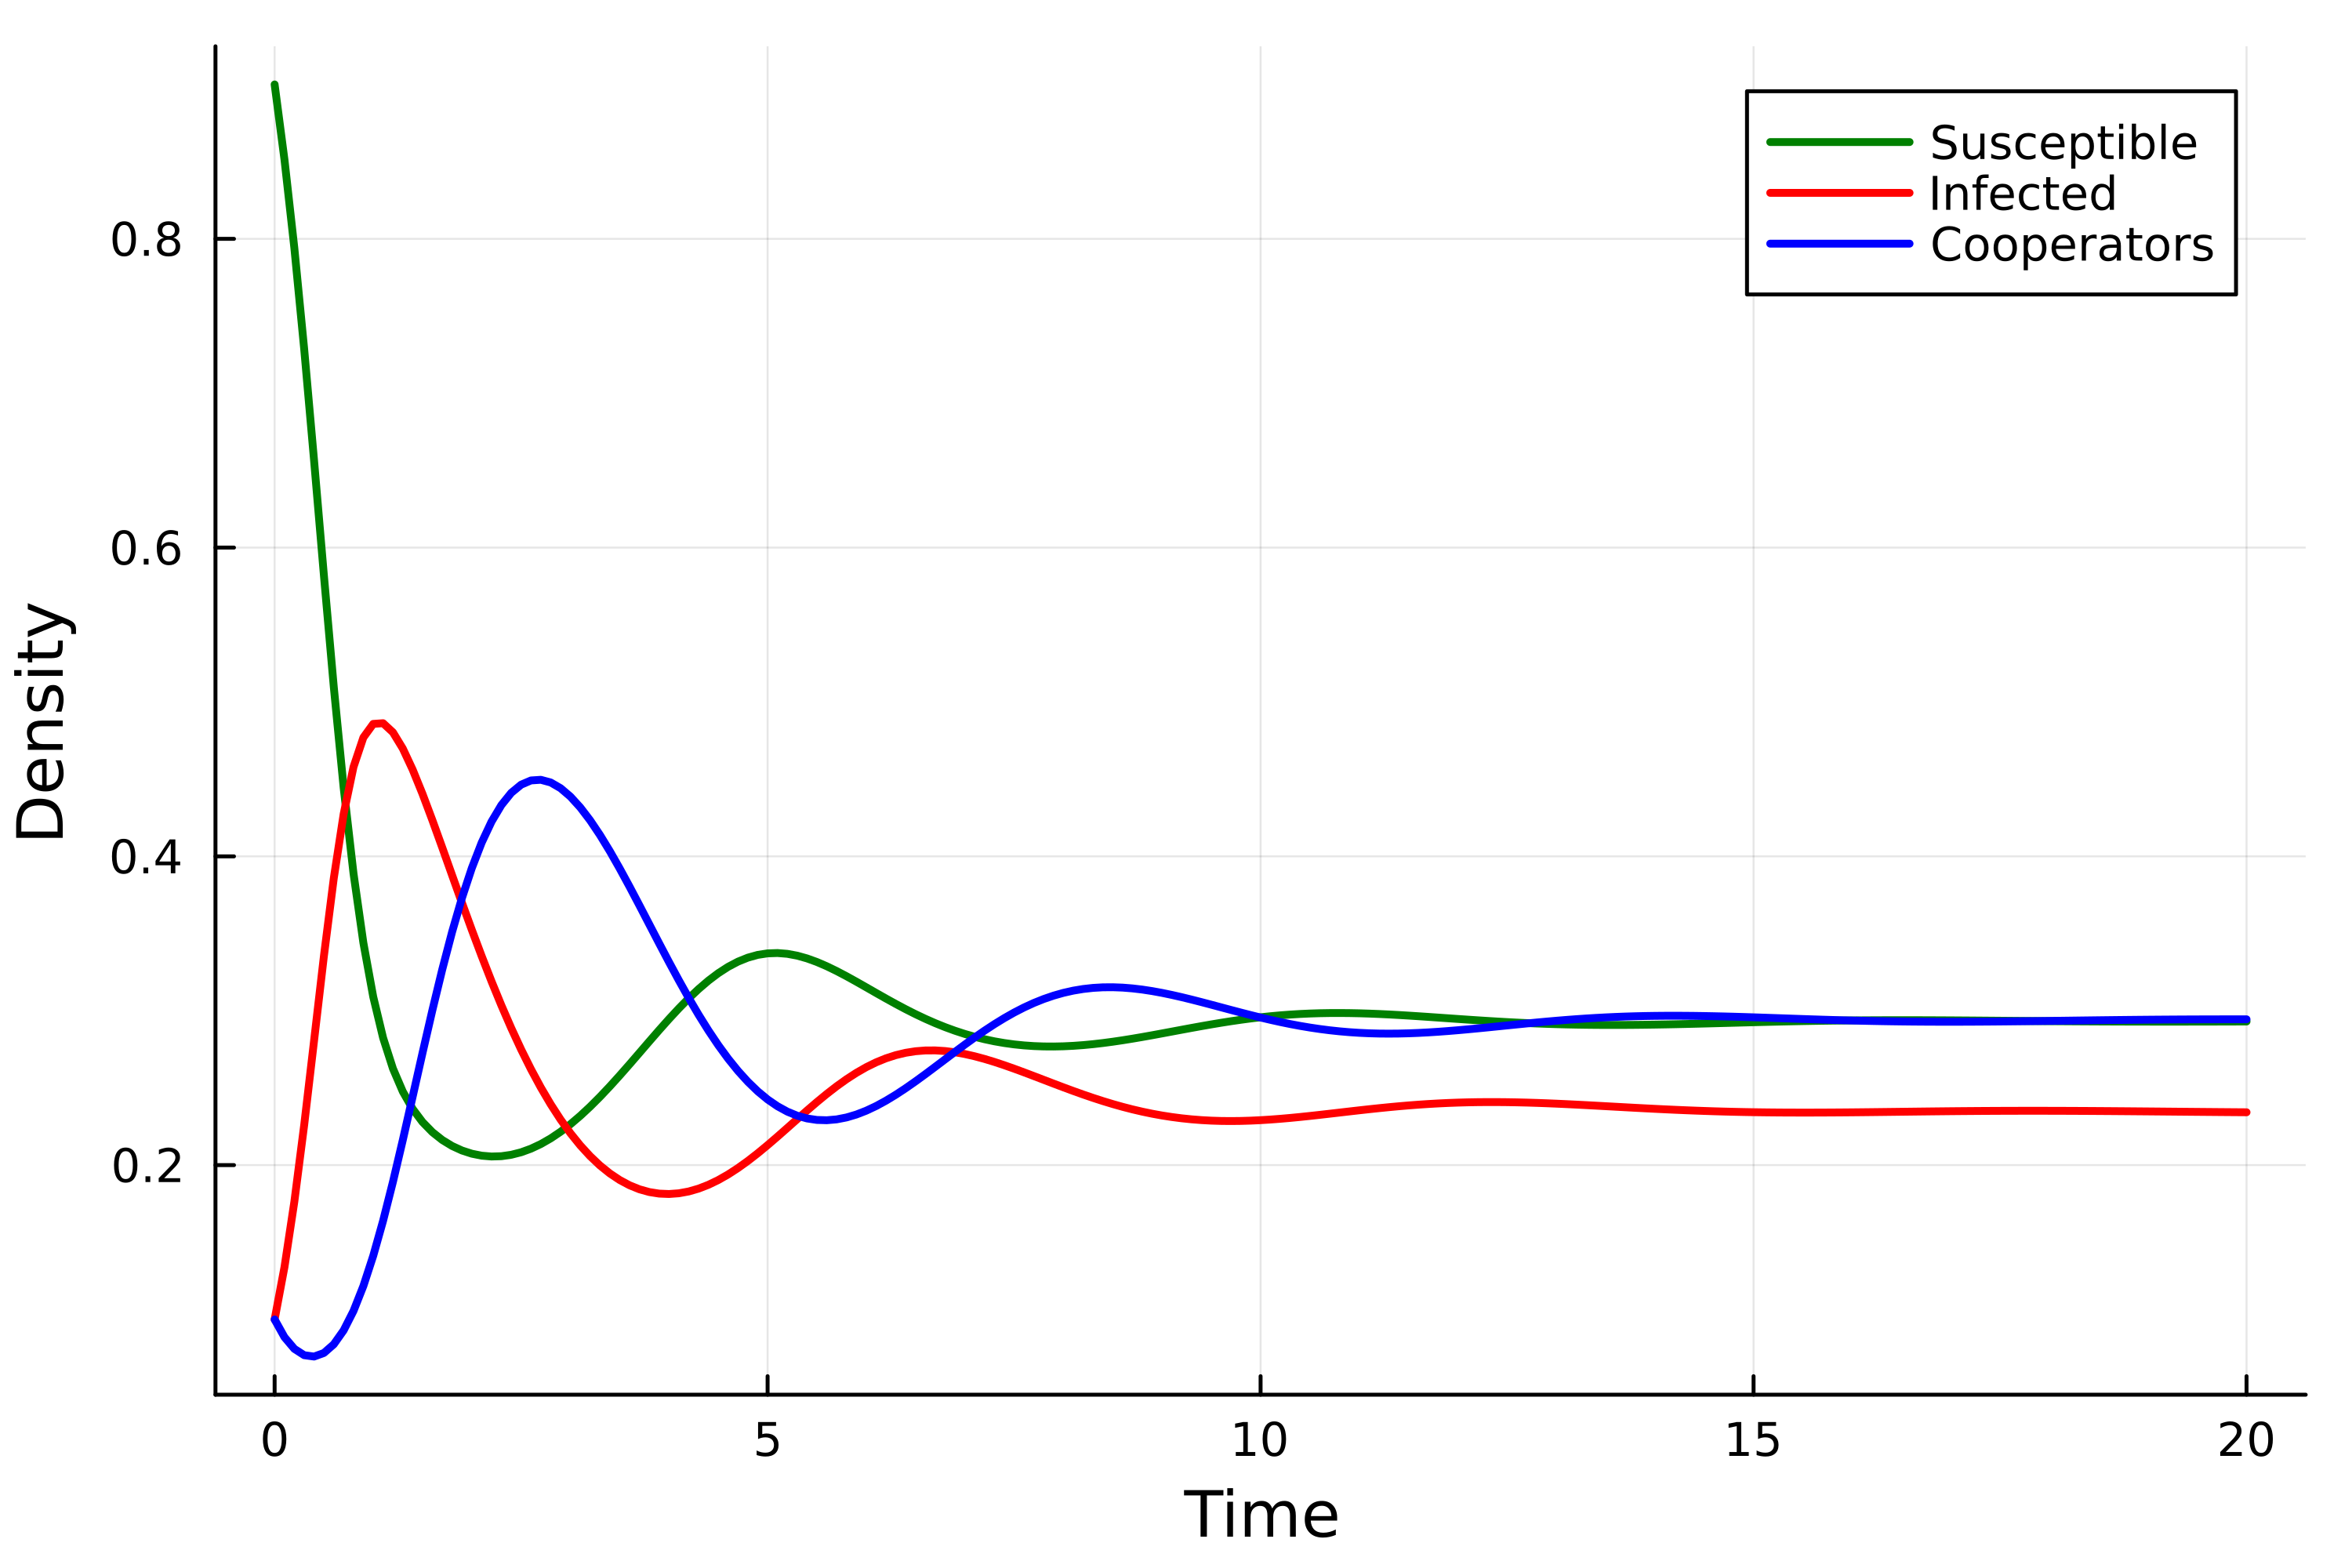

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\EPV_nocycle.png"

In [64]:

ptime_serie =ParTime(tspan = (0,20))
param_EPV_nocycle = parma_evo_comp(vit =7.5,rv = 0.1,p1 = 10,p2 = 0.5,var =0.1) 
sol = sim_mod(iniv ,param_EPV_nocycle ,ptime_serie,Vern9() )

display(time_plot(sol,:topright))

savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/EPV_nocycle.png")

#### Coopérateurs avec cycle

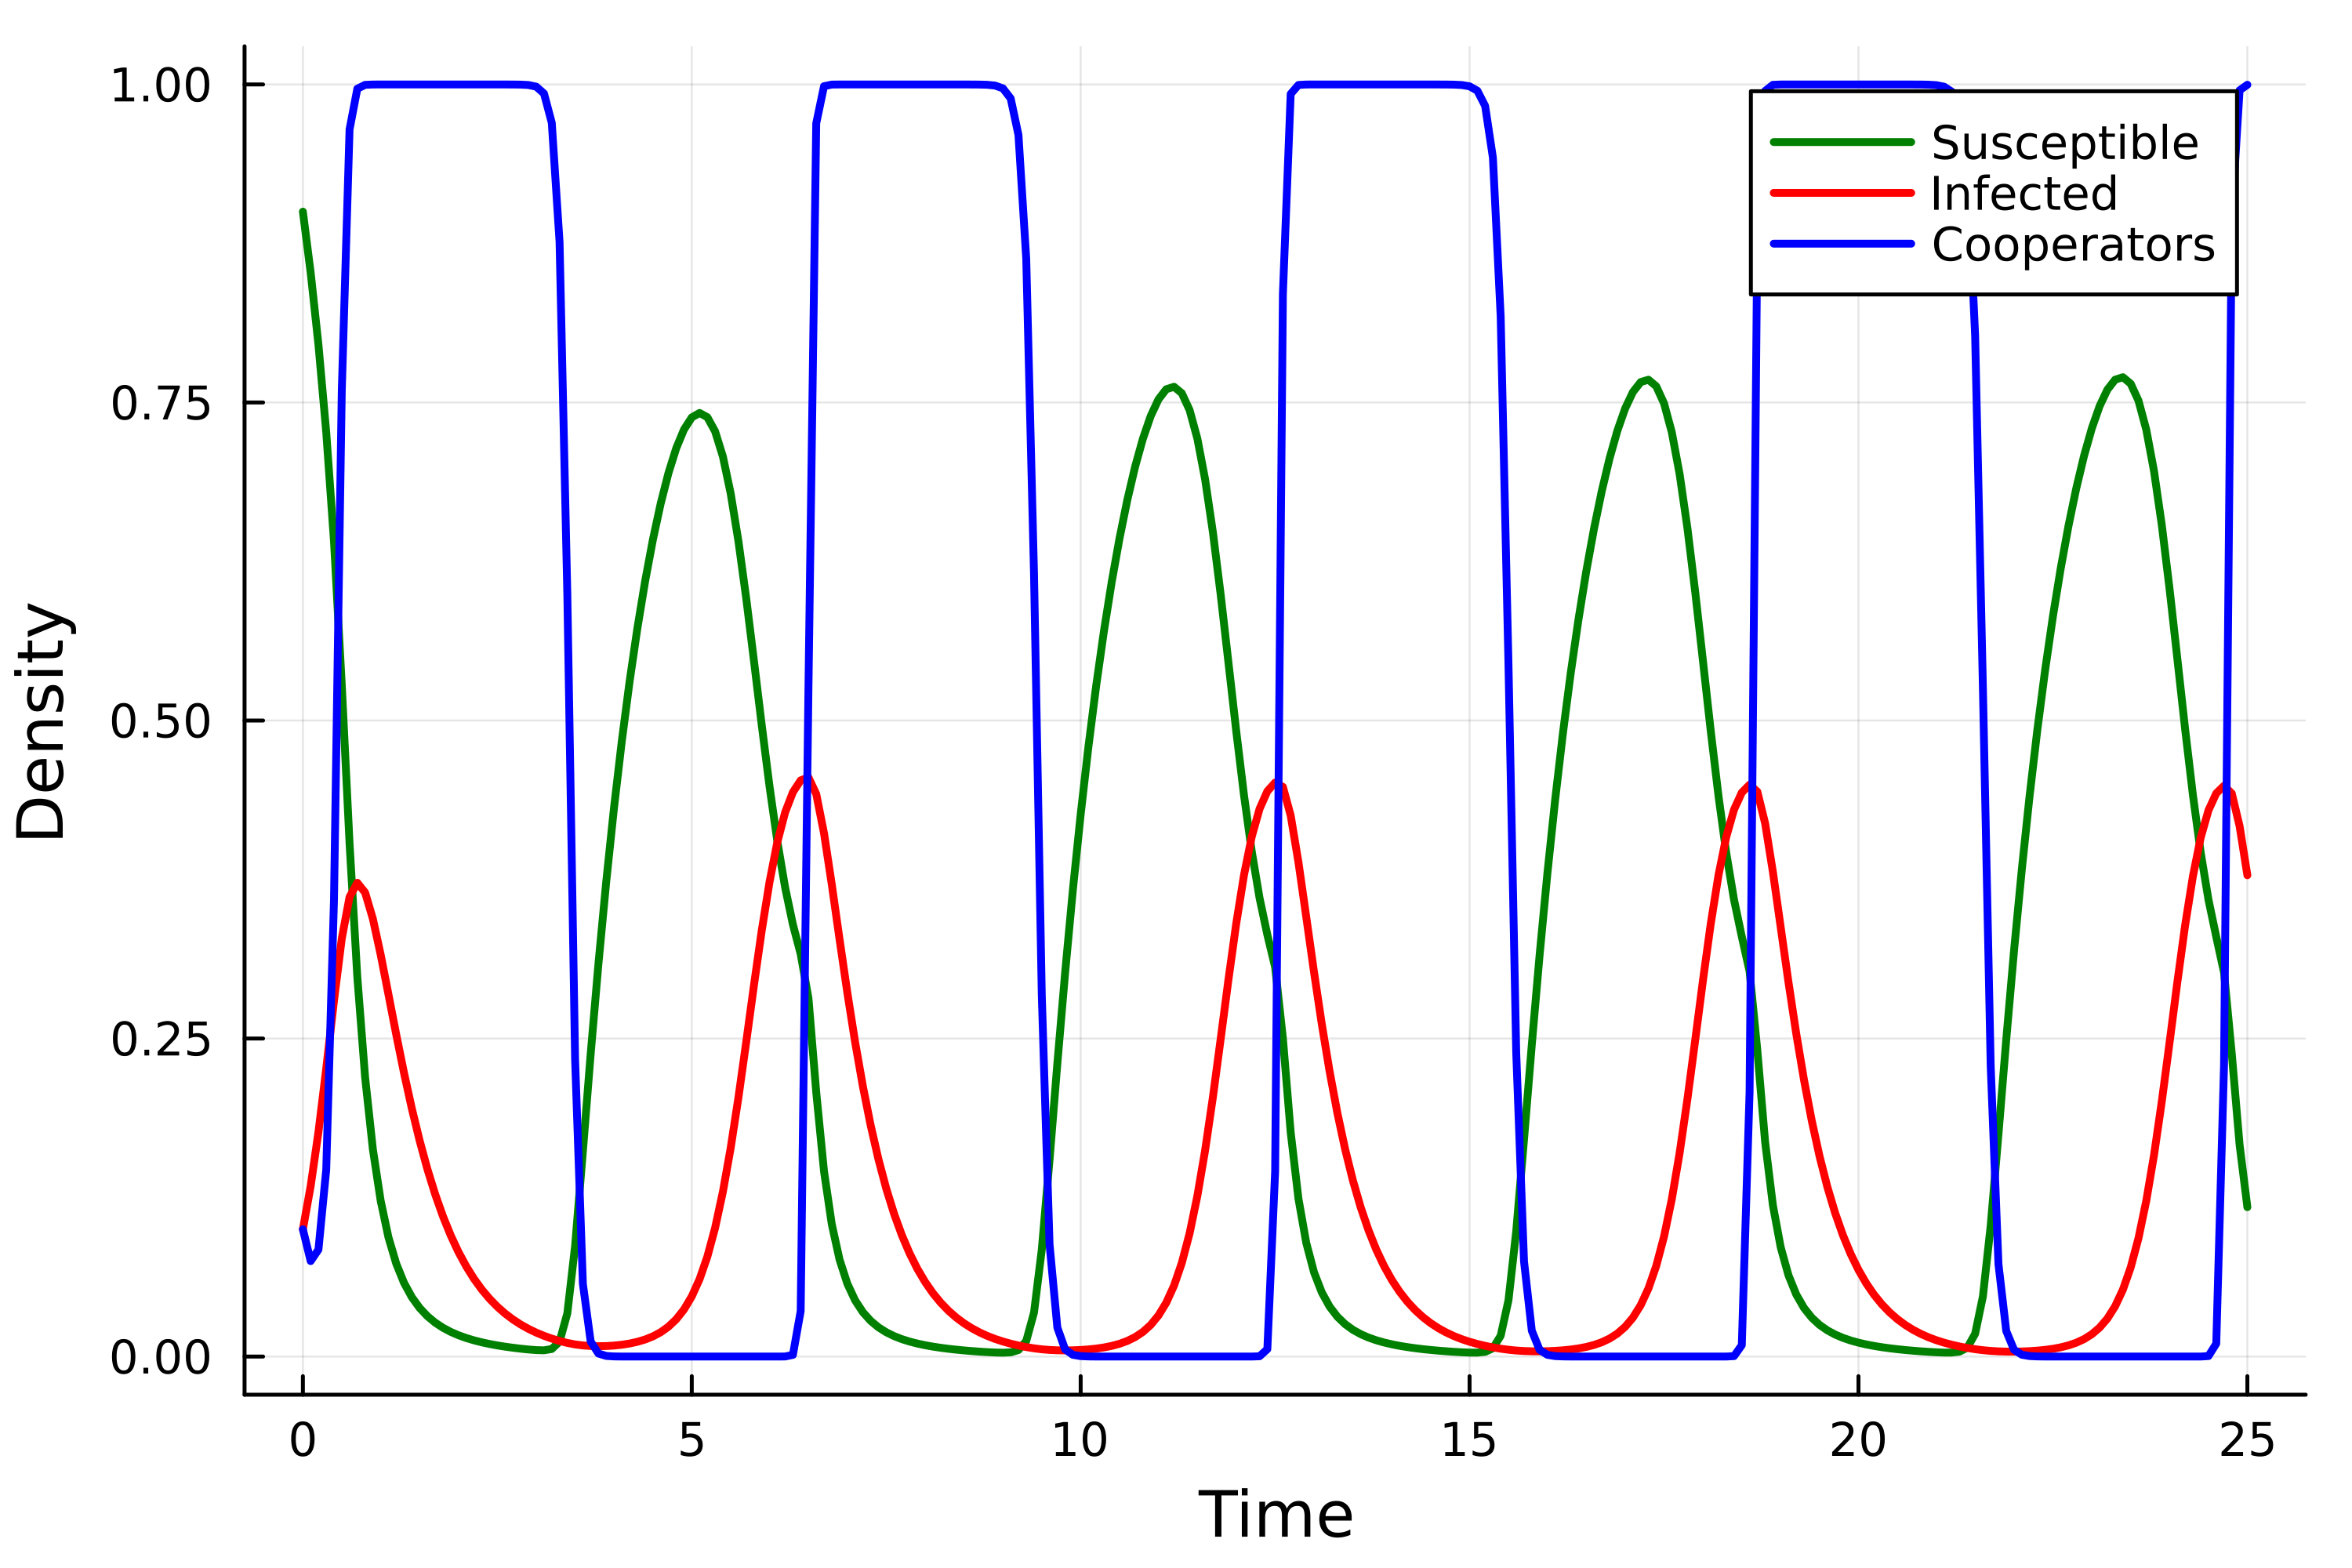

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\EPV_cycle.png"

In [65]:

ptime_serie =ParTime(tspan = (0,25))
param_EPV_cycle = parma_evo_comp(vit =100,rv = 0.05,p1 = 10,p2 = 0.5,var=0.1) 
sol = sim_mod(iniv ,param_EPV_cycle,ptime_serie,Vern9() )

display(time_plot(sol,:topright))

savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/EPV_cycle.png")

#### Virulence

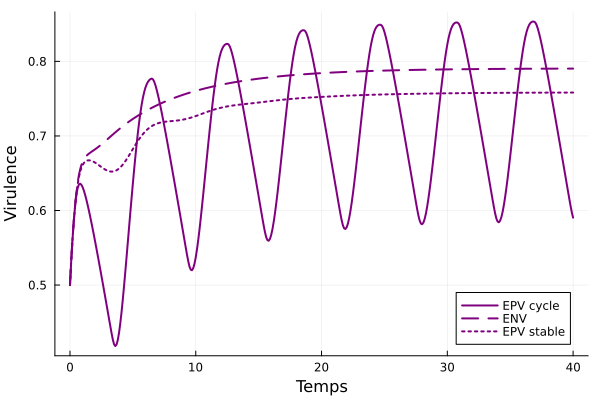

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\vir.png"

In [66]:

ptime_serie =ParTime(tspan = (0,40))

param_EPV_cycle = parma_evo_comp(vit =100,rv = 0.05,p1 = 10,p2 = 0.5,var=0.1) 
param_EPV_nocycle = parma_evo_comp(vit =7.5,rv = 0.1,p1 = 10,p2 = 0.5,var =0.1) 
param_ENV = parma_evo_comp(vit =10,rv = 0.3,p1 = 10,p2 = 0.5,var =0.1) 

sol_ENV = sim_mod(iniv ,param_ENV ,ptime_serie,Vern9() )
sol_EPV_nocycle = sim_mod(iniv ,param_EPV_nocycle,ptime_serie,Vern9() )
sol_EPV_cycle= sim_mod(iniv ,param_EPV_cycle ,ptime_serie,Vern9() )

x = sol_EPV_cycle.time

vir_EPV_cycle = sol_EPV_cycle.v
vir_ENV =sol_ENV.v
vir_EPV_nocycle = sol_EPV_nocycle.v



# Création du graphique
plt = plot(x, vir_EPV_cycle, label="EPV cycle", color="purple", linewidth=2,linestyle = :solid)
plot!(x, vir_ENV, label="ENV", color="purple", linewidth=2,linestyle = :dash)
plot!(x, vir_EPV_nocycle, label="EPV stable", color="purple", linewidth=2,linestyle = :dot)


# Ajout du titre et des labels
#title!("Virulence")
xlabel!("Temps")
ylabel!("Virulence")

display(plt)

savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/vir.png")

#### Nombre de mort

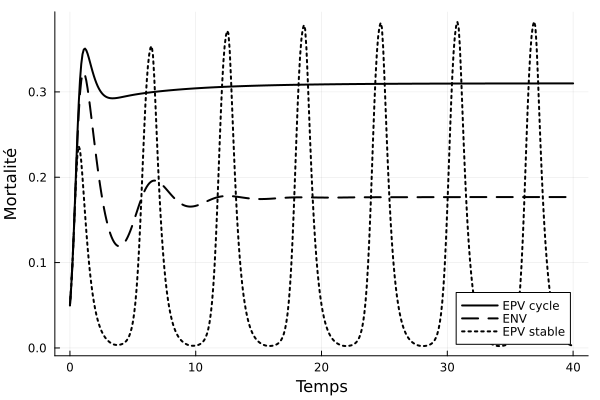

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\mortalite.png"

In [67]:

ptime_serie =ParTime(tspan = (0,40))

param_EPV_cycle = parma_evo_comp(vit =100,rv = 0.05,p1 = 10,p2 = 0.5,var=0.1) 
param_EPV_nocycle = parma_evo_comp(vit =7.5,rv = 0.1,p1 = 10,p2 = 0.5,var =0.1) 
param_ENV = parma_evo_comp(vit =10,rv = 0.3,p1 = 10,p2 = 0.5,var =0.1) 

sol_EPV_cycle = sim_mod(iniv ,param_ENV ,ptime_serie,Vern9() )
sol_ENV = sim_mod(iniv ,param_EPV_nocycle,ptime_serie,Vern9() )
sol_EPV_nocycle = sim_mod(iniv ,param_EPV_cycle ,ptime_serie,Vern9() )

x = sol_EPV_cycle.time

vir_EPV_cycle = sol_EPV_cycle.v .*sol_EPV_cycle.I
vir_ENV =sol_ENV.v .*sol_ENV.I
vir_EPV_nocycle = sol_EPV_nocycle.v .*sol_EPV_nocycle.I



# Création du graphique
plt = plot(x, vir_EPV_cycle, label="EPV cycle", color="black", linewidth=2,linestyle = :solid,legend= :bottomright)
plot!(x, vir_ENV, label="ENV", color="black", linewidth=2,linestyle = :dash)
plot!(x, vir_EPV_nocycle, label="EPV stable", color="black", linewidth=2,linestyle = :dot)


# Ajout du titre et des labels
#title!("Virulence")
xlabel!("Temps")
ylabel!("Mortalité")

display(plt)

savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/mortalite.png")

#### How evolution impact bifurcation

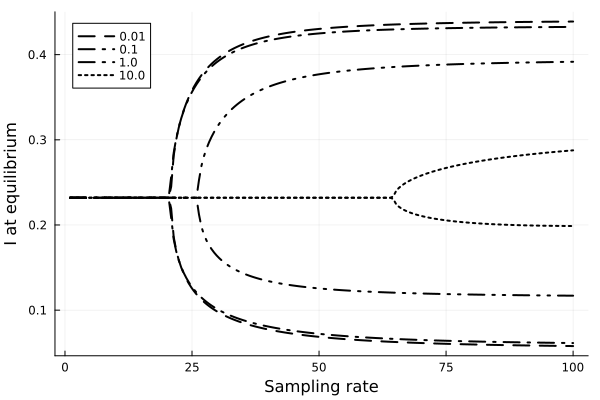

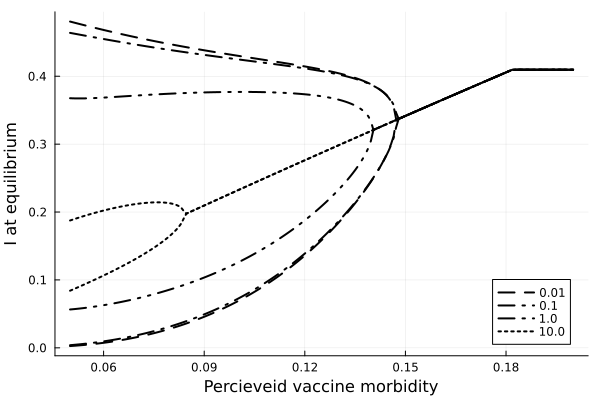

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\diag_1pbif_vacc.png"

In [68]:
diag_bif_vit=diagram_bif_1p_vit_var(200,1.0, 100.0,[0.01,0.1,1.0,10.0])

diag_bif_rv=diagram_bif_1p_rv_var(200,0.05, 0.2,[0.01,0.1,1.0,10.0])

display(diag_bif_vit)
savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/diag_1pbif_sampling.png")

display(diag_bif_rv)


savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/diag_1pbif_vacc.png")

### Bifurcation diagram with 2 parameters

#### Behavior in sampling rate and perceived vaccine cost plane

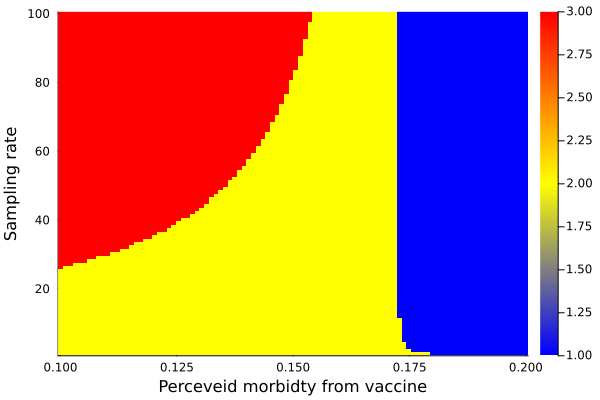

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\diag_bif_vir.png"

In [69]:
nbr_val = 100
low_vit = 1.0
high_vit = 100.0
low_rv = 0.1
high_rv = 0.2
Z = bifurcation_diagram_2p(nbr_val,ptime,Vern9(),low_vit,high_vit,low_rv,high_rv )
x = range(low_rv,stop = high_rv,length = nbr_val)
y = range(low_vit,stop = high_vit,length = nbr_val)
bif_diag =plot_bif_diag(x,y,Z,["blue","yellow","red"])
display(bif_diag)
savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/diag_bif.png")


Z2 = diagram_bif_vir(nbr_val,ptime,Vern9(),low_vit,high_vit,low_rv,high_rv )

heatmap(x, y, Z2, color=:twilight,dpi =500)

savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/diag_bif_vir.png")

In [70]:
# function mod_vac_evo_comp(init::SVector{4}, p::parma_evo_comp, t)
#     (;B,d,var,gamma0,vit,kappa,p1,p2,rho,form,form_biais,m) = p

#     S =init[1]
#     I =init[2]
#     vir =init[3]
#     x = init[4]

#     # if form ==  1
#     #     rap_cost = kappa
#     # elseif  form == 2 
#     #     rap_cost = kappa / (vir /(vir + mu))*m
#     # elseif  form == 3
#     #     rap_cost = kappa / (1 - exp(rho * vir * I)) * m
#     # end

#     # if form_biais == "lineaire"
#     #     I_biais = I
#     # elseif form_biais == "sur"
#     #     I_biais = 1 - exp(-5*I)
#     # elseif  form_biais == "sous"
#     #     I_biais = I^2
#     # elseif form_biais == "sur/sous"
#     #     I_biais = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
#     # elseif form_biais == "sous/sur"
#     #     I_biais = 1 / (1 + exp(10*(-I+0.5)))
#     # end
#     rap_cost = kappa / ((vir)/(d + vir))
#     I_biais = I

#     dS = B*(1-x) - d *S - beta1(vir,p) * S *I
#     dI = beta1(vir,p) * S *I - (d +  vir)*I
#     dv = var *(beta2(vir,p) * (S + gamma0 * I) - 1 ) 
#     dx = vit * x *(1 - x) * (  I_biais   - rap_cost)
#     return SVector(dS,dI,dv,dx)
# end

# Annexe 1: Perceived probabilty of being infected


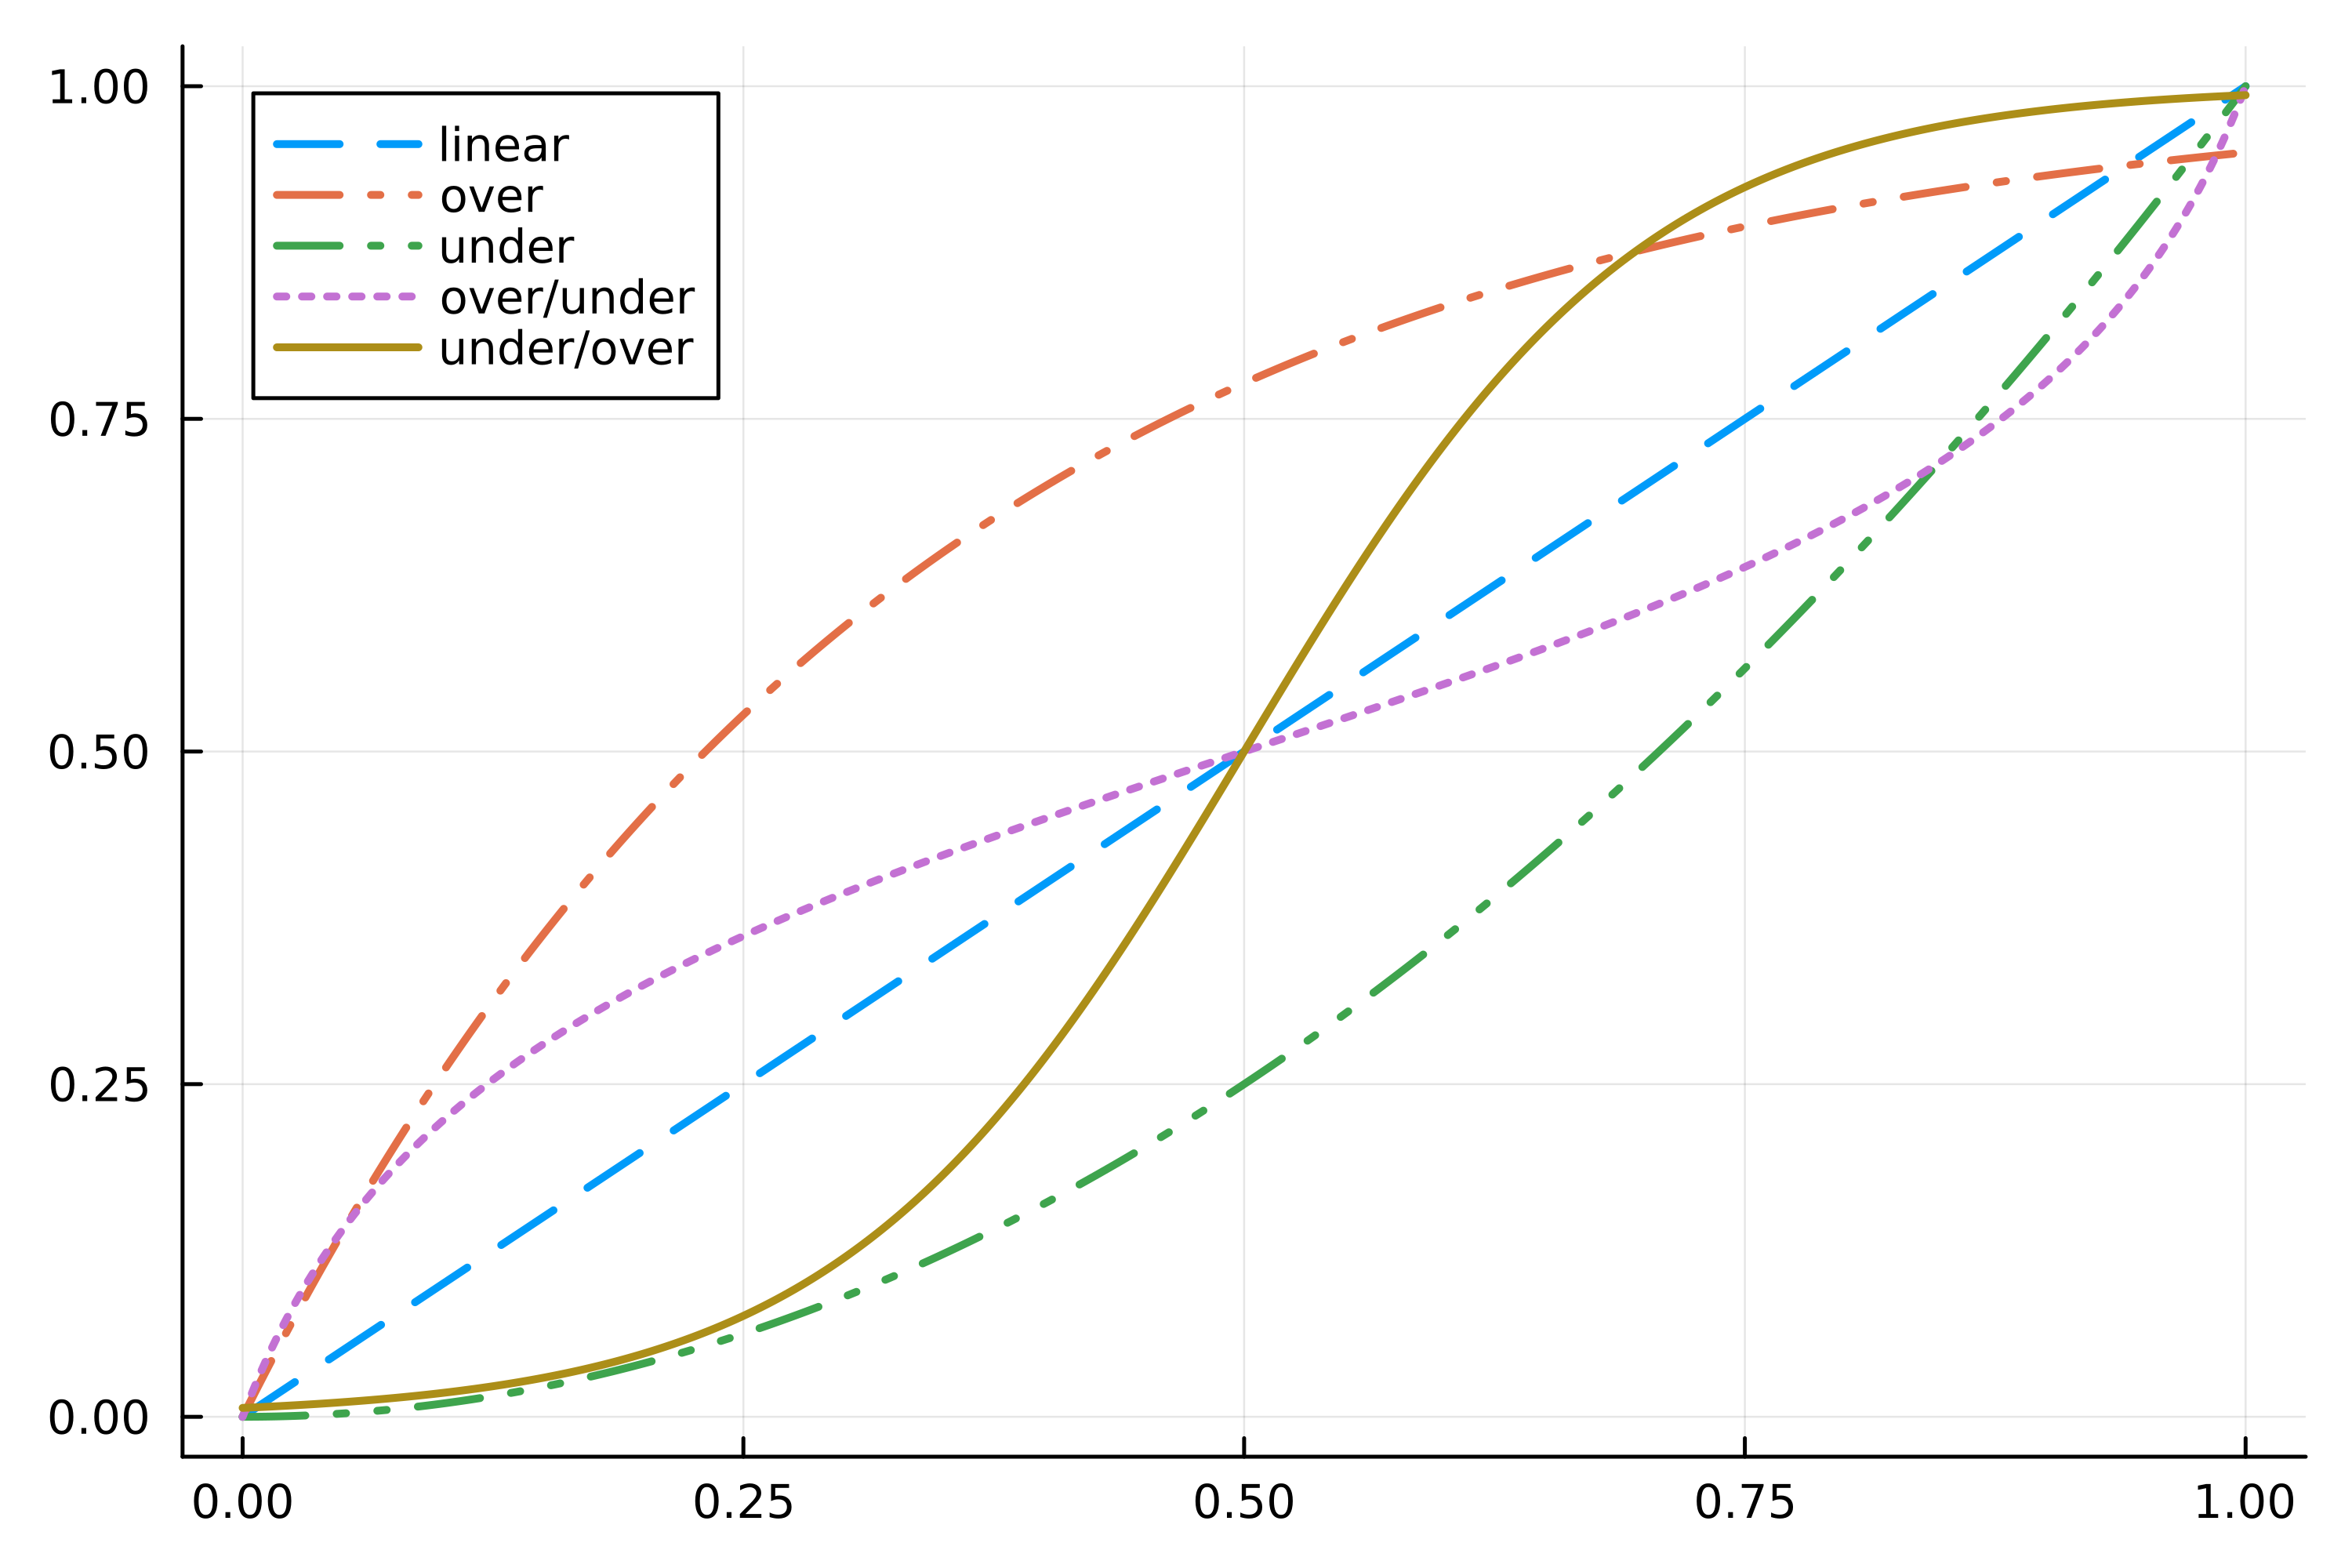

In [71]:
vec_x = range(0, stop=1, length=1000)
vec_lin = similar(vec_x)  # Crée un vecteur de la même taille pour stocker les valeurs de y
vec_over = similar(vec_x)
vec_under = similar(vec_x)
vec_over_under = similar(vec_x)
vec_under_over = similar(vec_x)

for i in eachindex(vec_x)
    I = vec_x[i]
    y = 1 - exp(-3*I)
    y2 = I^2
    y3 = ((I -1/2)* ( sqrt(1 - 3/4)))/ sqrt(1 - 3 * (I - 1/2 )^2 ) +1/2 
    y4 = 1 / (1 + exp(10*(-I+0.5)))

    vec_lin[i] = I  # Crée un vecteur de la même taille pour stocker les valeurs de y
    vec_over[i] = y
    vec_under[i] = y2
    vec_over_under[i] = y3
    vec_under_over[i] = y4

end

plot(vec_x, vec_lin, label="linear", linewidth=2,linestyle =linestyle_vec[1],dpi =500)
plot!(vec_x, vec_over, label="over", linewidth=2,linestyle =linestyle_vec[2])
plot!(vec_x, vec_under, label="under",  linewidth=2,linestyle =linestyle_vec[3])
plot!(vec_x, vec_over_under, label="over/under",  linewidth=2,linestyle =linestyle_vec[4])
plot!(vec_x, vec_under_over, label="under/over",  linewidth=2,linestyle =linestyle_vec[5])

# savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/trade_off.png")

# Annexe 2: trade-off 

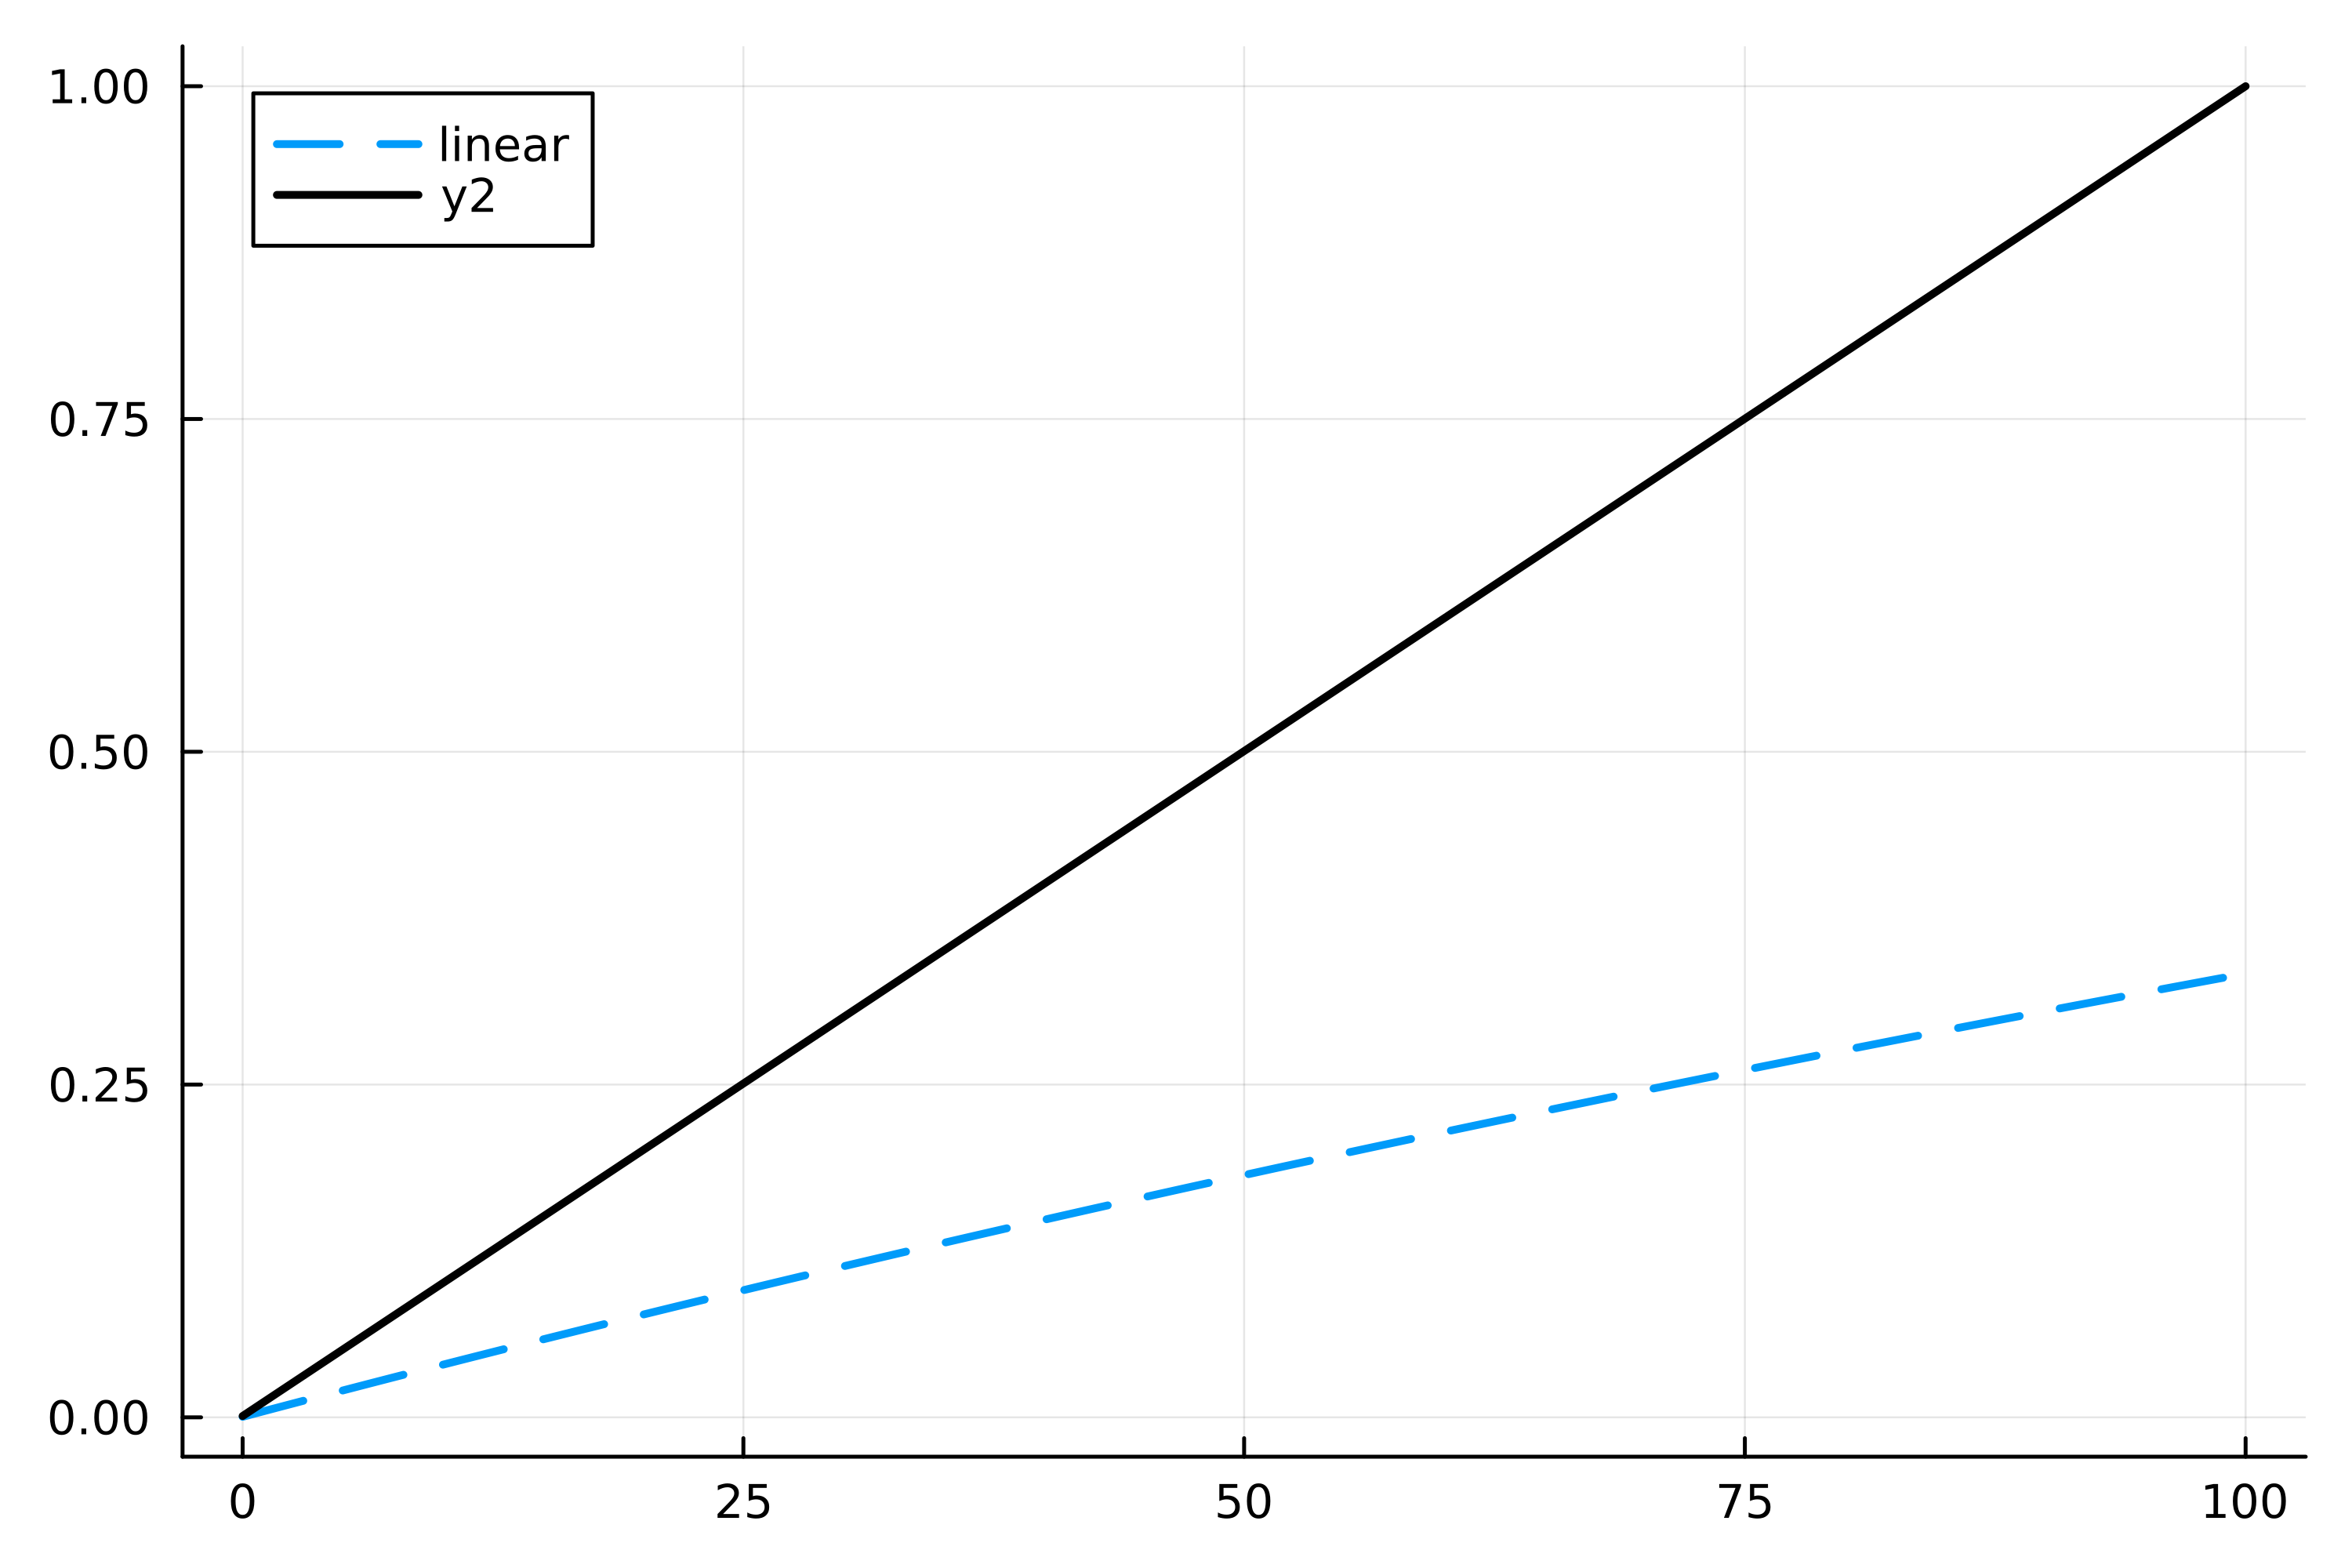

In [72]:
vec_x = range(0, stop=100, length=1000)
vec_lin = similar(vec_x) 
vec_lin2 = similar(vec_x) 
g=0.1
p1=2
p2=5

for v in eachindex(vec_x)
    vir=v/1000
    I = (p1*vir)/(p2+vir)
    I2 = vir
    vec_lin[v] = I 
    vec_lin2[v] = I2
end
plot(vec_x, vec_lin, label="linear", linewidth=2,linestyle =linestyle_vec[1],dpi =500)
plot!(vec_x, vec_lin2,linewidth=2,color ="black",dpi =500)

# Annexe 2: Existence condition

### Display  bifurcation diagram

In [73]:
### package and function definition

In [74]:
# Pkg.add("SymPy")
# Pkg.add("Roots")

using SymPy
using Roots

function func_existence(v,pi_C,g)

    pi_D = v / (g + 1 + v)

    bfunc = (10 * v) / (0.5 + v)

    cond1= bfunc*( pi_C/ pi_D) 

    cond2= bfunc / (g + 1 + v) -1

        if cond1 >cond2
            # tab_res = 0
            res =1
        end
        if cond2 >cond1
            # tab_res=1
            res =2

        end
    # for i in 1:length(tab_res)
    #     if tab_res != tab_res
    #         display()
    return res
end

func_existence (generic function with 1 method)

In [75]:
for π_C_val in range(0.,0.99,1000)
    # Définir le symbole
    @syms v

    # Paramètres numériques
    g_val = 0.001
    p_val = 0.1
    # π_C_val = 0.2

    # Définir b(v) et π_D(v)
    b_func = (10 * v) / (0.5 + v)
    π_D_val = v / (g_val + 1 + v)

    # Calcul de b'(v)
    b_prime = diff(b_func, v)

    # Membre droit de l'équation
    rhs = b_func / (g_val + 1 + v + p_val * b_func * (π_C_val / π_D_val))

    # Construire l'équation à résoudre
    eq = Eq(b_prime, rhs)

    # Résolution symbolique (peut être lent ou ne pas réussir selon la complexité)
    sols = solve(eq, v)

    # println("Solutions symboliques pour v :")
    # display(sols)

    # Si pas de solution symbolique claire, on peut essayer la version numérique :
    # # Exemple : chercher v entre 0.01 et 10
    # println("\nRecherche numérique si nécessaire...")
    # v_val = find_root(b_prime - rhs, (0.01, 10.0))  # méthode de bissection
    # println("Solution numérique approximative : v ≈ ", v_val)
    f(v_val) = N(subs(b_prime - rhs, v => v_val))
    v_numeric = find_zero(f, (0.01, 2.0))
    # println("Solution numérique : v ≈ ", v_numeric)
    # println("for ",π_C_val," value we have")
    res=func_existence( v_numeric,π_C_val,g_val)
    if res == 1
        
        pi_c_lim = π_C_val
        display(pi_c_lim)
        break
    end

end


0.1744144144144144

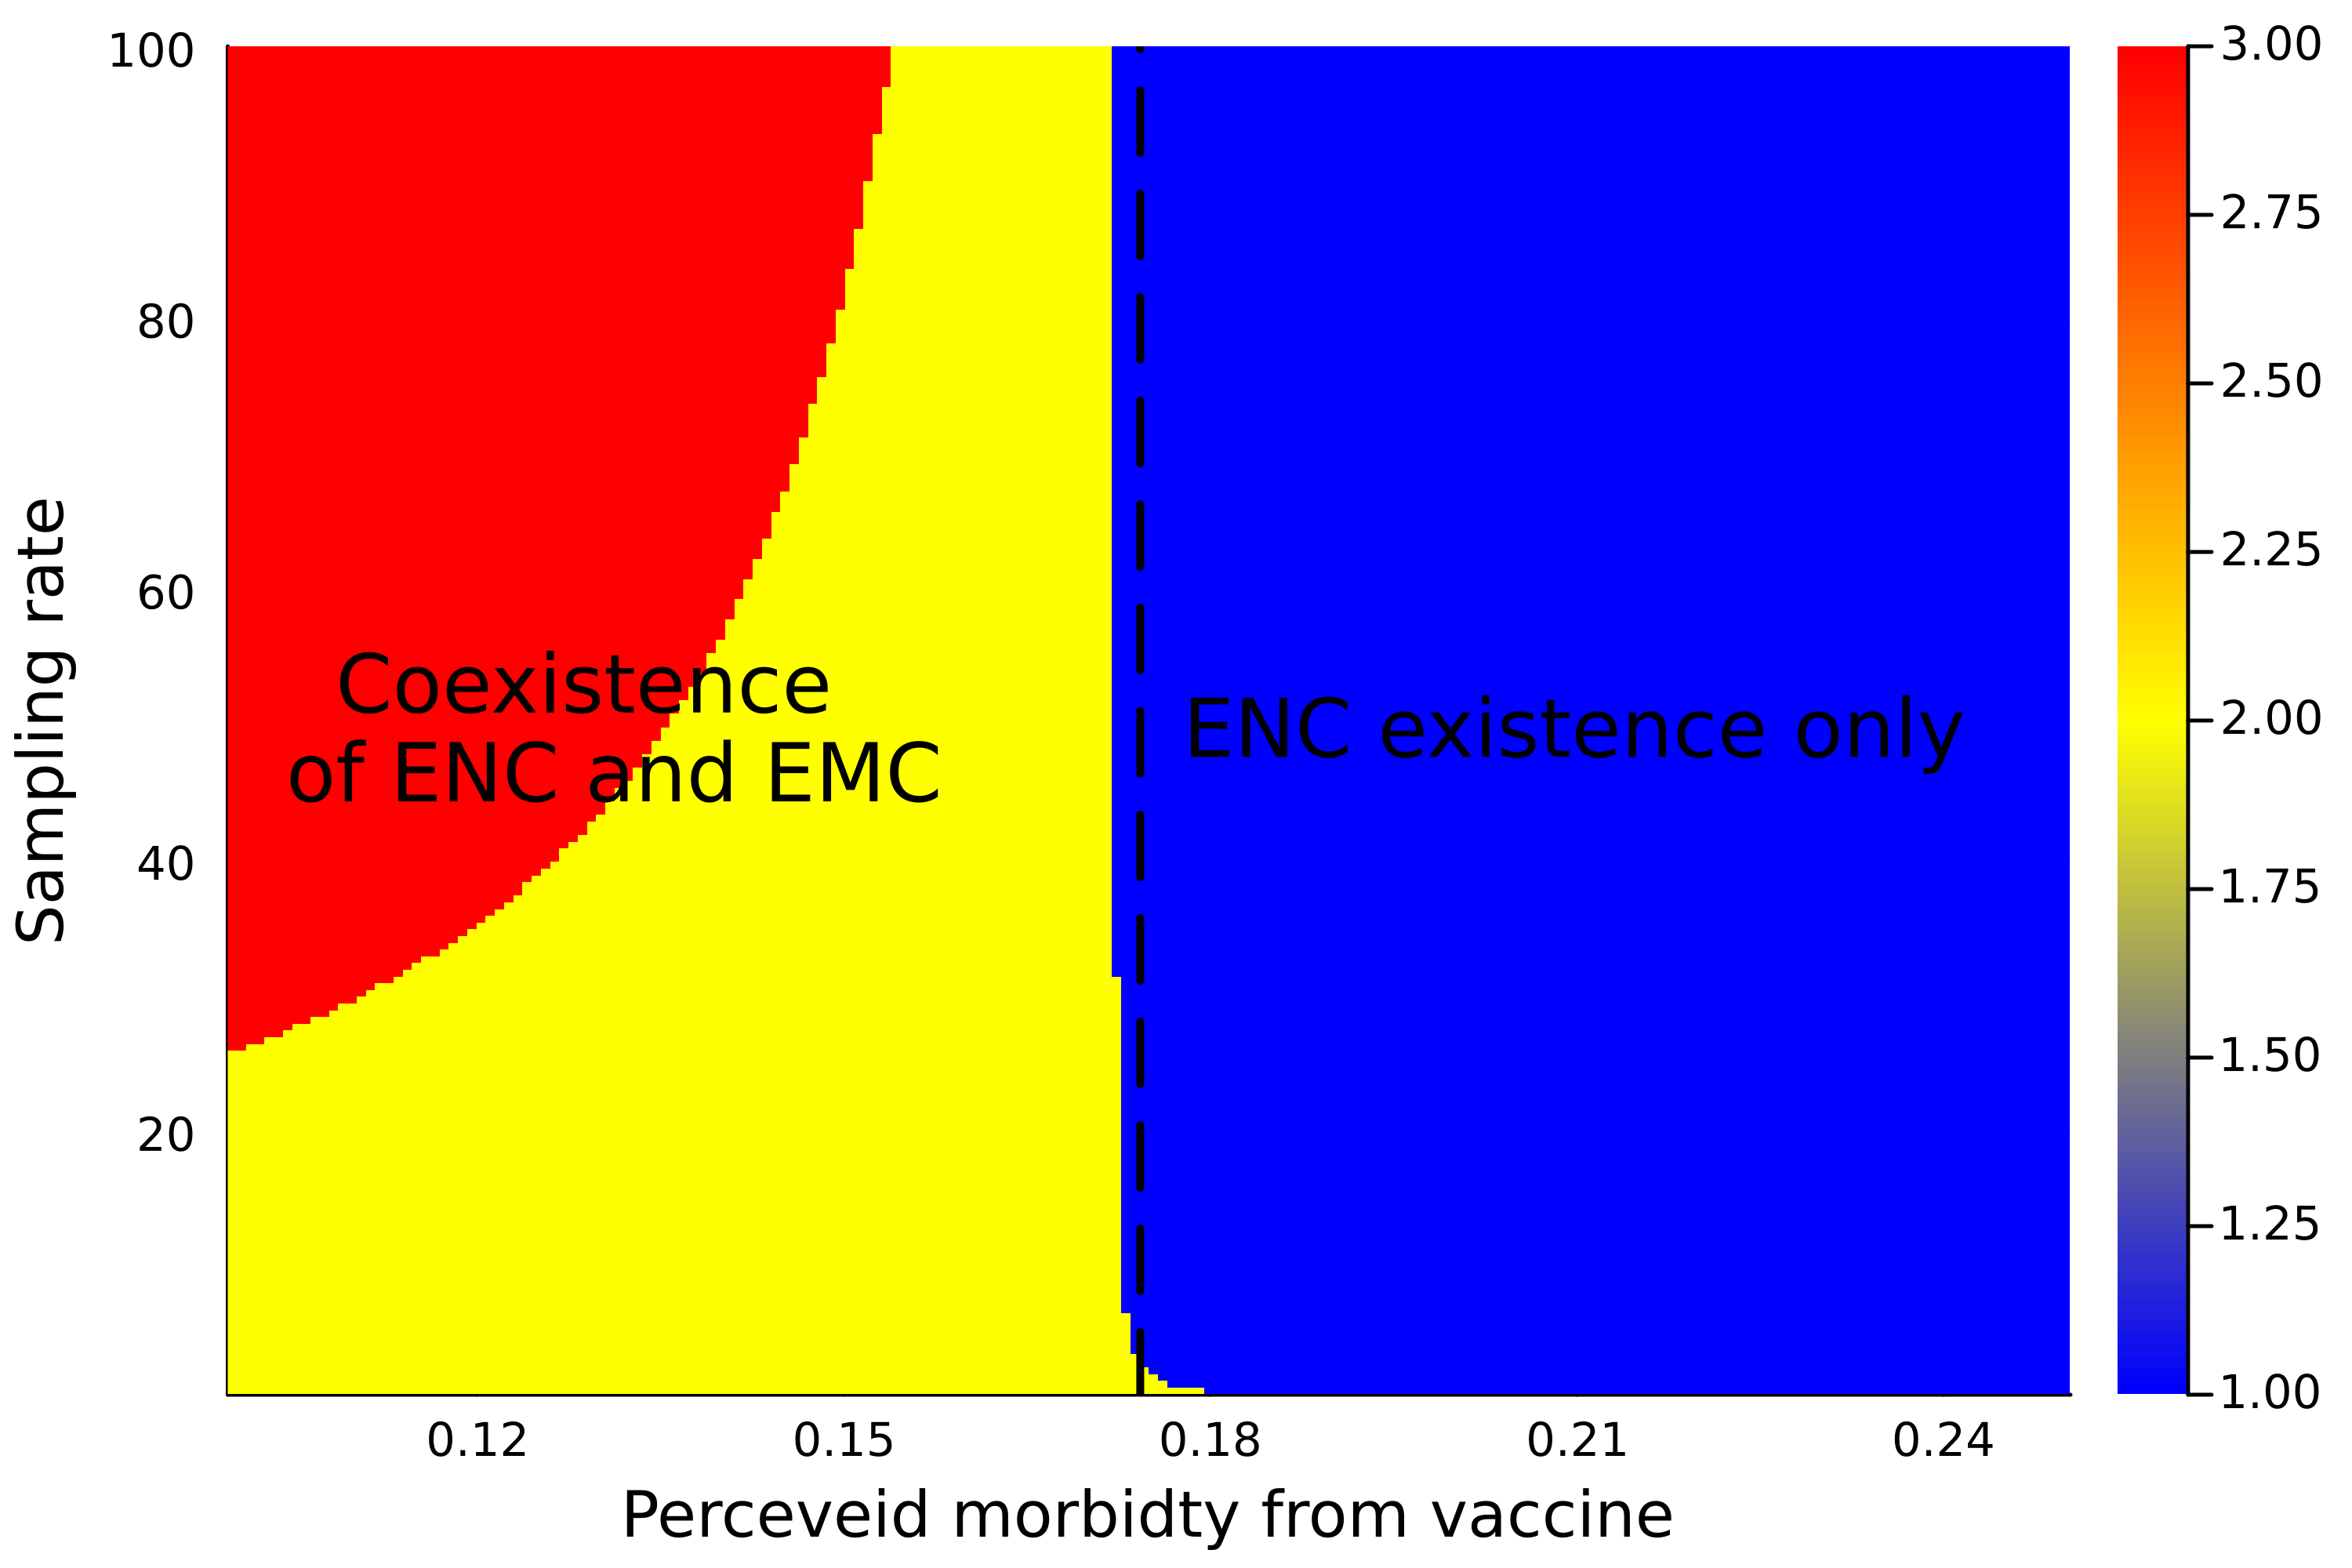

"C:\\Users\\monau\\Desktop\\THESE\\article\\Vaccination_behavior_and_virulence_evolution\\FIgures\\plot_brut\\Coexistence.png"

In [76]:
nbr_val = 200
low_vit = 1.0
high_vit = 100.0
low_rv = 0.1
high_rv = 0.25
Z = bifurcation_diagram_2p(nbr_val,ptime,Vern9(),low_vit,high_vit,low_rv,high_rv )
x = range(low_rv,stop = high_rv,length = nbr_val)
y = range(low_vit,stop = high_vit,length = nbr_val)
#bif_diag =plot_bif_diag(x,y,Z,["blue","yellow","red"])




bif_existence = heatmap(x, y, Z, levels=[1,2,3], color=["blue","yellow","red"],dpi =500)
vline!(bif_existence ,[0.17427427427427428], color=:black, linewidth=2, linestyle=:dash,legend = false)
# annotate!()
annotate!([(0.13, 50, ("Coexistence \n of ENC and EMC", 14, :black, :center)), (0.21, 50, ("ENC existence only", 14, :black, :center))])

xlabel!("Perceveid morbidty from vaccine")
ylabel!("Sampling rate")
#title!("Bifurcation diagram")
display(bif_existence )
x
savefig("C:/Users/monau/Desktop/THESE/article/Vaccination_behavior_and_virulence_evolution/FIgures/plot_brut/Coexistence.png")